# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [12]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [13]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

Global seed set to 42


42

# Load data from Azure blob

In [14]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Eval Model

In [15]:
exp_model_dir = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_13_1_yes_koppen_2Y_3D_230401_0511" # TODO: Replace to your model dir
best_model_path = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_13_1_yes_koppen_2Y_3D_230401_0511/lightning_logs/version_0/checkpoints/epoch=10-step=55077.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*2 # 1 year
ENCODER_LEN = 24*3   # 3 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 17520.


In [16]:
def setup_tsdataset_yeskoppensub(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["koppen_main", "koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'],
      time_varying_unknown_categoricals=["gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [7]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_yeskoppensub(train_df, val_df, None, ENCODER_LEN)

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1287576
Subset num val timesteps: 446760


## Default Evaluation

In [9]:
# # Eval on Validation set
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# # Print Model Eval on Validation Set
# start = default_timer()
# print(f"Start eval on validation.")
# val_q_predictions = best_tft.predict(val_dataloader, mode="quantiles", show_progress_bar=True, return_x=False)
# eval_time = default_timer() - start
# print(f"Val eval time: {eval_time}")

# # Get actuals
# val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# # save eval results - also we can resume eval at a later point in time
# with open(exp_model_dir + os.sep + "val_actuals.pkl", "wb") as fout:
#     pickle.dump(val_actuals, fout)

# with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "wb") as fout:
#     pickle.dump(val_q_predictions, fout)

Start eval on validation.


Predict: 100%|██████████| 1738/1738 [02:22<00:00, 12.23 batches/s]

Val eval time: 142.1025466850001


In [10]:
# reload = False

# if reload:
#     # load eval results - also we can resume eval at a later point in time
#     with open(exp_model_dir + os.sep + "val_actuals.pkl", "rb") as fin:
#         val_actuals = pickle.load(fin)

#     with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "rb") as fin:
#         val_q_predictions = pickle.load(fin)

#     #Eval on Validation set
#     val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

    
# val_predictions = val_q_predictions[:, :, 3] # p50 == estimation
# val_p90 = val_q_predictions[:, :,5] # p90 == estimation
# #del val_q_predictions

# # Unmasked evaltaion
# eval_metric = get_eval_metrics(val_actuals, val_predictions, None, val_p90)
# print(f"Unmasked Val eval evaluation: {eval_metric}")

# # Masked evlationa
# start = default_timer()
# mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))
# masked_eval_metric = get_eval_metrics(val_actuals, val_predictions, mask, val_p90)
# eval_time = default_timer() - start
# print(f"Masked Val eval time: {eval_time}")
# print(f"Masked Val eval evaluation: {masked_eval_metric}")

Unmasked Val eval evaluation: {'rmse': 3.726851224899292, 'mae': 2.071681022644043, 'nse': 0.7169995307922363, 'r2': 0.7169995223488477, 'p50_loss': 0.5119325518608093, 'p90_loss': 0.2996406555175781}
Masked Val eval time: 12.702417973000138
Masked Val eval evaluation: {'rmse': 3.7844791412353516, 'mae': 2.1030664443969727, 'nse': 0.7186856865882874, 'r2': 0.7186857152130753, 'p50_loss': 0.5177719593048096, 'p90_loss': 0.3053414523601532}


# Model Interpreation

In [19]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_yeskoppensub(train_df, val_df, None, ENCODER_LEN)
raw_predictions = best_tft.predict(validation, mode="raw") #,  show_progress_bar=True)

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1287576
Subset num val timesteps: 446760




Predict:   4%|▍         | 277/6952 [01:09<27:44,  4.01 batches/s]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x700 with 1 Axes>,
 'decoder_variables': <Figure size 700x675 with 1 Axes>}

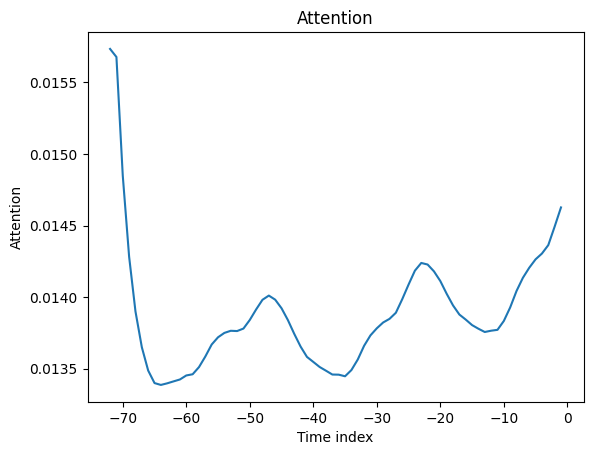

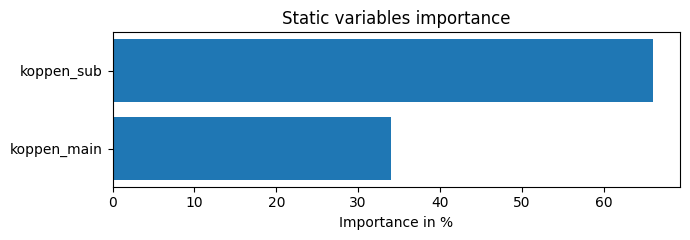

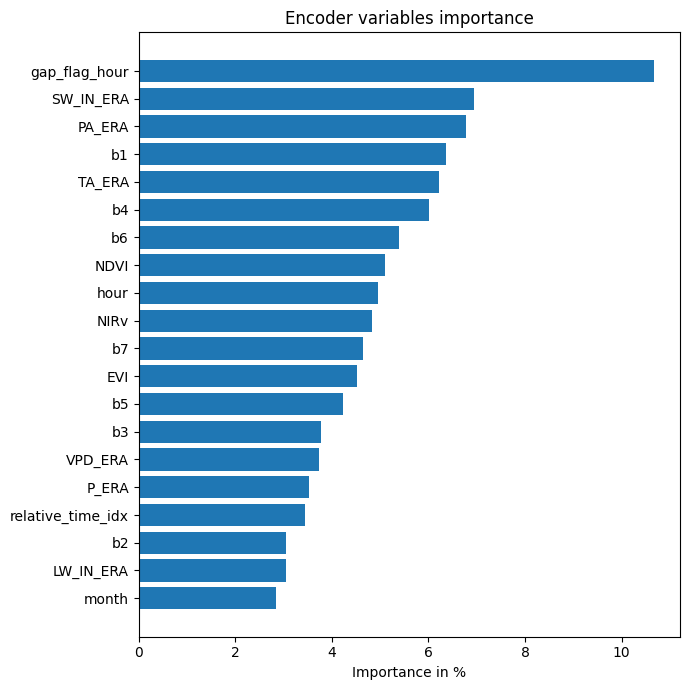

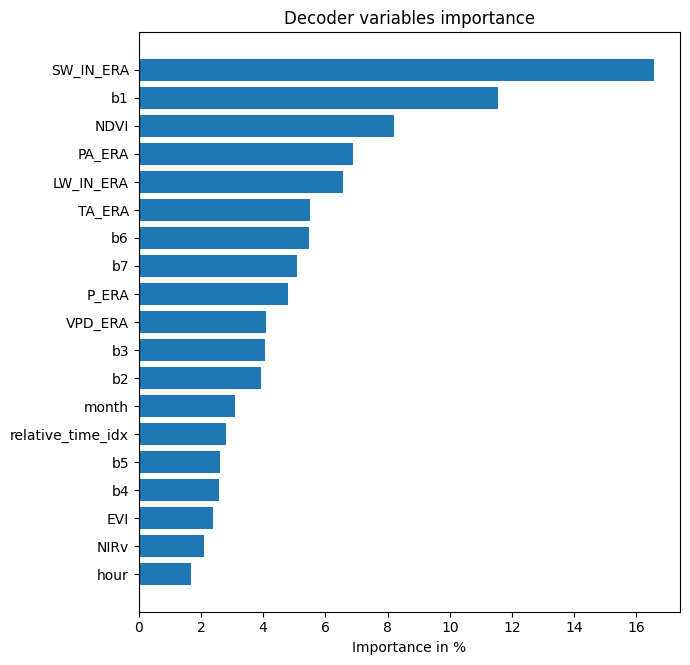

In [20]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Feature-Level Attention

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

Error in callback <function _draw_all_if_interactive at 0x7f8c50b87eb0> (for post_execute):


Predict:   3%|▎         | 224/6952 [12:19<6:10:08,  3.30s/ batches]


ValueError: Image size of 700x11122400 pixels is too large. It must be less than 2^16 in each direction.

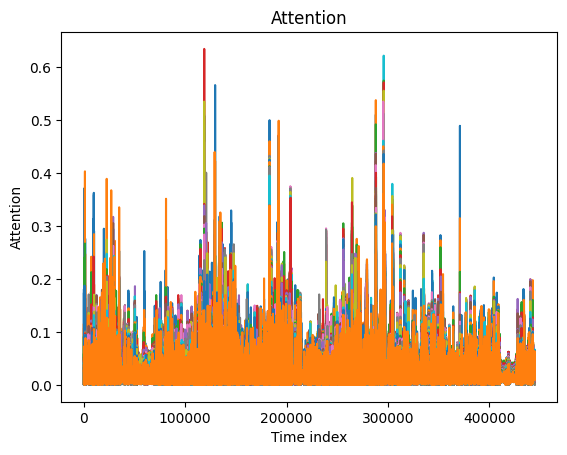

ValueError: Image size of 700x11122400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 700x1.11224e+07 with 1 Axes>

In [21]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="none")
best_tft.plot_interpretation(interpretation)

In [ ]:
for key in raw_predictions.keys():
    print(f"key: {key}, shape: {raw_predictions[key].shape}")
    
print(raw_predictions["encoder_attention"][0])

In [ ]:
# Pick one step, find the highest attention timestep, find 